<a href="https://colab.research.google.com/github/siddhantwade/datascienceshowcase/blob/master/model_comparison_miniproject_california_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Comparison Mini Project - California Housing

This is an on going project thgat compares the performance of various models on the task of prediciting the value of a real estate property as observed in the popular California Housing Data Set. 

To limit the scope of this project we shall be using a pre-cleaned dataset that does not show any missing value or null values. 



In [0]:
#importing required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

#importing required models and model methods as required
from sklearn.model_selection import train_test_split
m sklefroarn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import graphviz

In [0]:
#getting data
# I have combined the classicially available test and training sets into a single dataframe
# I have done this so during splitting I can shuffle the data as per my needs to tune performance
# the .append function can be used to combine the two sets available in sklearn library
# When using colab, the data sets are available in the Sample Data repo under the Files section of your notebook

df1 = pd.read_csv("/content/sample_data/california_housing_train.csv")
df2 = pd.read_csv("/content/sample_data/california_housing_test.csv")

#sampledata = pd.read_csv("data.csv")

df = df1.append(df2)
originaldf = df

In [0]:
#let's take a look at the data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 2999
Data columns (total 9 columns):
longitude             20000 non-null float64
latitude              20000 non-null float64
housing_median_age    20000 non-null float64
total_rooms           20000 non-null float64
total_bedrooms        20000 non-null float64
population            20000 non-null float64
households            20000 non-null float64
median_income         20000 non-null float64
median_house_value    20000 non-null float64
dtypes: float64(9)
memory usage: 1.5 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc60c0f4dd8>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

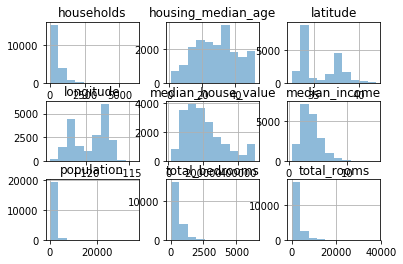

In [0]:
plt.figure()

df.hist(alpha = 0.5)

In [0]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-119.566172,35.626750,28.627750,2637.051550,537.991800,1425.557650,499.525450,3.872132,207082.716750
std,2.003609,2.136141,12.582229,2176.314757,420.631119,1131.048487,381.729517,1.900356,115557.055856
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1451.000000,296.000000,788.000000,280.000000,2.562500,119800.000000
50%,-118.490000,34.250000,29.000000,2126.000000,434.000000,1166.000000,409.000000,3.536000,179800.000000
75%,-118.000000,37.710000,37.000000,3149.000000,647.000000,1724.000000,604.000000,4.745325,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


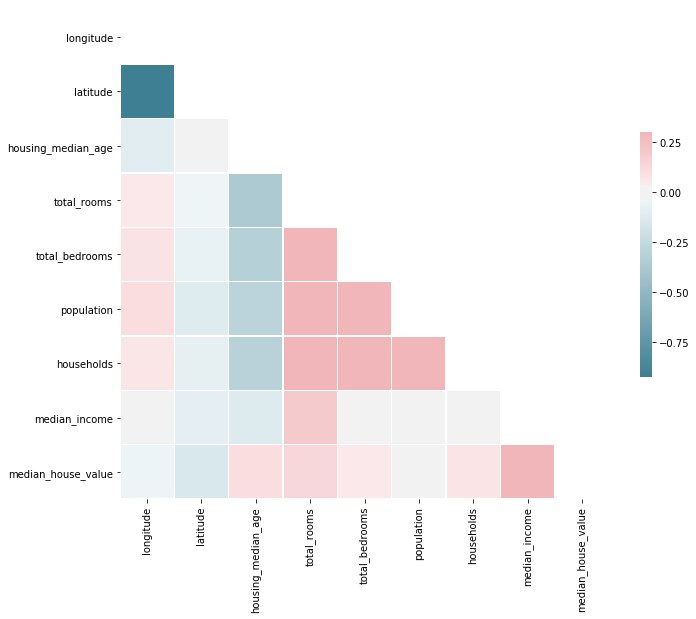

In [0]:
#building coorelation matrix

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
#we create an original set to source data from
dforiginal = df



In [0]:
# we will now use df as the modelling set
#use list of "","","" enclosed in box braces to drop multiple cols

df = dforiginal.drop("total_bedrooms", axis = 1) 


In [0]:
#let's take a look at our modelling dataframe now

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 2999
Data columns (total 9 columns):
longitude             20000 non-null float64
latitude              20000 non-null float64
housing_median_age    20000 non-null float64
total_rooms           20000 non-null float64
total_bedrooms        20000 non-null float64
population            20000 non-null float64
households            20000 non-null float64
median_income         20000 non-null float64
median_house_value    20000 non-null float64
dtypes: float64(9)
memory usage: 1.5 MB


In [0]:
#defining features
x = df.iloc[:,:-1]
#defining targets
y = df.iloc[:,-1:]

#splitting the data
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30)

In [0]:
#splitting to display variance
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 10, shuffle = True)


In [0]:
scorelist = []
iteration = [1,2,3,4,5,6,7,8,9,10]

In [0]:
#Fitting Linear Regressor

LR = LinearRegression()
LR.fit(xtrain,ytrain)


traininglossLR = LR.score(xtrain,ytrain)
testinglossLR = LR.score(xtest,ytest)
print("Training loss - ", traininglossLR)
print("Testing loss - ", testinglossLR)

print("Feature Weights are -", LR.coef_)


#scorelist.append(testinglossLR)



Training loss -  0.6380109233993083
Testing loss -  0.7406390059969175
Feature Weights are - [[-4.30534200e+04 -4.27888498e+04  1.15679275e+03 -8.42165595e+00
   1.14453237e+02 -3.82274913e+01  4.78493012e+01  4.04123253e+04]]


Linaer models although showing variance will not show different coefficients for the featue set

[[-4.31256136e+04 -4.28653669e+04  1.15814662e+03 -8.35045320e+00
   1.14339474e+02 -3.81945464e+01  4.75119304e+01  4.03497459e+04]]
   
   [[-4.31154190e+04 -4.28257153e+04  1.15609145e+03 -8.35542878e+00
   1.14296057e+02 -3.82486762e+01  4.77164593e+01  4.03488523e+04]]
   
 
 
 [[-4.30709016e+04 -4.27887044e+04  1.15567844e+03 -8.42090820e+00
   1.14457051e+02 -3.82395169e+01  4.78606659e+01  4.03884341e+04]]
   
 [[-4.30749755e+04 -4.28063310e+04  1.15452294e+03 -8.35519986e+00
   1.14134633e+02 -3.82429840e+01  4.78399847e+01  4.03514761e+04]]

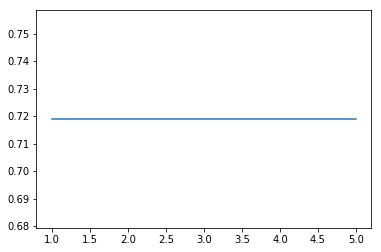

In [0]:
plt.plot(iteration, scorelist)

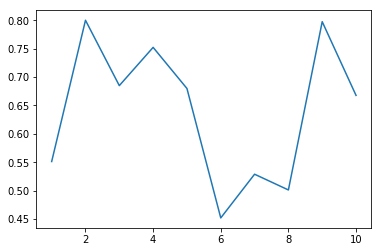

In [0]:
scorelist = []
iteration = [1,2,3,4,5,6,7,8,9,10]

for i in iteration:
  
  #splitting to display variance
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)

  #Fitting Linear Regressor

  LR = LinearRegression()
  LR.fit(xtrain,ytrain)


  traininglossLR = LR.score(xtrain,ytrain)
  testinglossLR = LR.score(xtest,ytest)
  #print(traininglossLR)
  #print(testinglossLR)

  #print(LR.get_params())
  
  scorelist.append(testinglossLR)
  
plt.plot(iteration, scorelist)

In [0]:
print(scorelist)

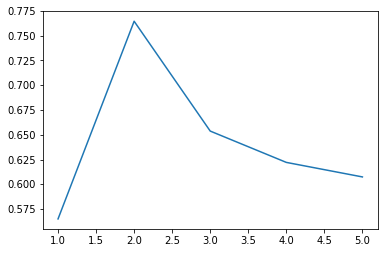

In [0]:
plt.plot(iteration, scorelist)

In [0]:
#splitting to display variance
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 5)

  #Fitting Linear Regressor

  LR = LinearRegression()
  LR.fit(xtrain,ytrain)


  traininglossLR = LR.score(xtrain,ytrain)
  testinglossLR = LR.score(xtest,ytest)
  print(traininglossLR)
  print(testinglossLR)

  #print(LR.get_params())
  
  scorelist.append(testinglossLR)

0.6382524646557046
0.2031667077651259


In [0]:
print(scorelist)

[0.7667300423265966, 0.5680314407698085, 0.5474306207153067, 0.03324451356936653, -0.04725886241146715]


In [0]:
scorelist = scorelist[:-1]

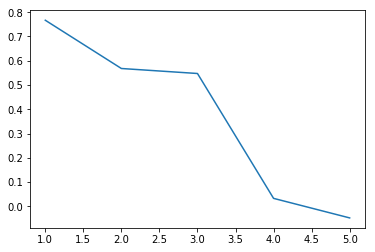

In [0]:
plt.plot(iteration, scorelist)

In [0]:
#Using Ridge Regression (L2 regularisation)
from sklearn.linear_model import Ridge

ridgeLR = Ridge(alpha = 1)
ridgeLR.fit(xtrain,ytrain)


traininglossridgeLR = ridgeLR.score(xtrain,ytrain)
testinglossridgeLR = ridgeLR.score(xtest,ytest)

print(traininglossridgeLR)
print(testinglossridgeLR)

0.6388938053782709
0.6518172539668234


In [0]:
from sklearn.linear_model import Lasso

lassoLR = Ridge(alpha = 1)
lassoLR.fit(xtrain,ytrain)

traininglosslassoLR = lassoLR.score(xtrain,ytrain)
testinglosslassoLR = lassoLR.score(xtest,ytest)

print(traininglosslassoLR)
print(testinglosslassoLR)


0.6388938053782709
0.6518172539668234


**Analysis on using Linear Regression**

**Vanilla version of LR -**

Training loss : 0.6388938079

Testing loss  : 0.6518185676146591


**Ride Regression L2 -**
 
0.6388938053782709

0.6518172539668234


**Lasso Regression l1 -**

0.6388938053782709

0.6518172539668234


**Analysis -**

Although linear regression does not fit the data very well, it will not show high degree of variance, that is if we retrain the model on the same data on each such training iteration the model will perform almost the same. 

However complex models will although fit the data better, they will show high degree of variance that is the will perform differently after re-training on same data and also if the data changes slightly. 

Below is an example


# Using Ransac Regressor

RANSAC (RANdom SAmple Consensus) algorithm.

RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. More information can be found in the general documentation of linear models.

**We are going to run Ransac multiple times and record observations**



In [0]:
from sklearn.linear_model import RANSACRegressor

ransacR = RANSACRegressor()
ransacR.fit(xtrain, ytrain)

#ransacR.score(xtrain,ytrain)
traininglossransacR = ransacR.score(xtrain,ytrain)
testinglossransacR = ransacR.score(xtest,ytest)

print(traininglossransacR)
print(testinglossransacR)

0.3241192441535008
0.7188337383396297


**Observations**

Iteration 1 - 

0.40279365680595725

0.5978635223695535

Iteration 2 - 

0.4895082652701116


0.6170210282185535

Iteration 3 - **Best fit**

0.5582286892065771

0.767279356068632

Iteration 4 - 

0.41852707293959845

0.6489107521146353

Accuracy of saved and loaded model
0.7119229578158638

# Saving Models
When working with complex models, its better to save the best model for later use.

In [0]:
#saving the model using pickle

import pickle

filename = 'finalized_model.sav'
pickle.dump(ransacR, open(filename, 'wb'))

In [0]:
#Loading and using a pre-saved model

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(xtest, ytest)
print(result)

0.7119229578158638


# **Using one of the most complex models**

The magic with decision trees is that although this algorithm fits the data very optimistically we have the capability to prune the tree and prevent it from overfitting data to our own liking. Meaning we have the ability to define how complex we want the model to be.

In [0]:
dtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15
dtree.fit(xtrain,ytrain)

#ransacR.score(xtrain,ytrain)
traininglossdtree = dtree.score(xtrain,ytrain)
testinglossdtree = dtree.score(xtest,ytest)

print(traininglossdtree)
print(testinglossdtree)

0.6997925564300607
0.7992898572003765


**Analysis of Dtree**

Iteration 1 - 


1.0

0.1992289373083762

This means that the tree is showing no training loss, means it fits the training data 100% but performs very poorly on test data, this is another way of detecting variance.

---

Iteration 2 -

0.9997253857001949

0.4521182121500316

When we reduced the complexity of the tree to a max depth of 25 levels immediately we see a drop in ability to fit data but we see a substantial increase in ability to predict test data, this is the justification that variance has reduced in our model

---


Iteration 3- max depth 15

0.9557919969594201

0.7201287095240858


By reduct depth of tree to 15, we have marginally reduced the training accuracy but signifianctly gained prediction accuracy. This is a good tradeoff

---


**THE DEVIL OF DATA**

Now i re-split the data by executing the train test split method above, the same model that was giving us excellent result of ~71% now performs poorly on new data.

0.9561743947897237

0.6980553120732594


**let's save the current model and test if on different data**

I will save the model
Run the split again
Import the saved model 
Test it on the new data
Asses results

In [0]:
filename = 'dtree.sav'
pickle.dump(dtree, open(filename, 'wb'))



NameError: ignored

In [0]:
loaded_dtree = pickle.load(open(filename, 'rb'))
result = loaded_dtree.score(xtest, ytest)
print(result)

0.9379607777538903


As you can see above that the exported model which was earlier performing poorly, is not giving accuracy of 0.9665740174940533 on test data.

--- 

On repeating the steps again the model gives an accuracy of 
0.9379607777538903

This is a problem of variance that complex models will show, they perform poorly or unpredictably when data changes, this can be a huge issue to compensate in production. 



Visualising your Dtrees

In [0]:
#sklearn has a plot_tree function to plot trees in terminal
#for larger trees without pruning, the execution will take 5-10mins
#if the tree is big then you won't be able to see individual node parameters
#for detailed visualisation you can use Graphviz library for quick results


print(plot_tree(dtree))

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fc623204ea0> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
#using Graphviz
#these processes can take a long time to generate the tree, patience please


dot = export_graphviz(dtree,
                        out_file=None,
                        filled=True,
                        impurity=None,
                        )

graph = graphviz.Source(dot)
graph.render("dtree_render")

KeyboardInterrupt: ignored

# Testing the variance of Dtrees against Linear Model



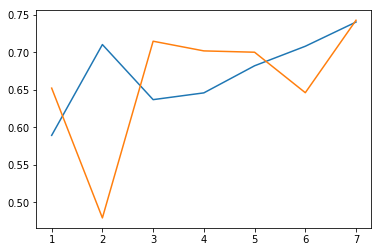

In [0]:
#READ
#first try vanila trees
#then try pruning levels
#then try pruning number of samples



scorelistvarlr = []
scorelistvardtree = []
iteration = [1,2,3,4,5,6,7]# ,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
  
  varLR = LinearRegression()
  varLR.fit(xtrain,ytrain)
  scorevarLR = varLR.score(xtest,ytest)
  
  
  vardtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15 #min_samples_split
  vardtree.fit(xtrain,ytrain)
  scorevardtree = vardtree.score(xtest,ytest)
  
  
  
  scorelistvarlr.append(scorevarLR)
  scorelistvardtree.append(scorevardtree)
  

  
plt.plot(iteration,scorelistvarlr, label = 'LR')
plt.plot(iteration,scorelistvardtree, label = 'Dtree')
  


In [0]:
dforiginal.describe()


AttributeError: ignored

In [0]:
df.describe()

argument# Ensembling

Ensembling is the process of building many smaller models also known as stumps that fit a fragment of your data but working together can as an aggregated model output perform much better than a single complex model

--- 

Let's first try Gradient Boosting Ensembler

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7300168136327555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7474828222582637


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7547757704675968


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7745963853876953


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7762903968368811


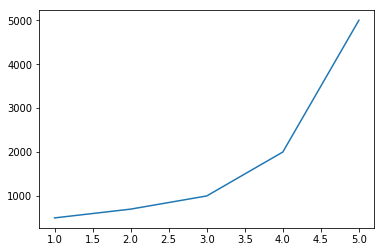

In [0]:
argumentlist = [500,700,1000,2000,5000]
iteration = [1,2,3,4,5]

for i in argumentlist:
  gbr = GradientBoostingRegressor(n_estimators = i, learning_rate = 0.03)

  gbr.fit(xtrain,ytrain)

  #ransacR.score(xtrain,ytrain)
  traininglossgbr = gbr.score(xtrain,ytrain)
  testinglossgbr = gbr.score(xtest,ytest)

  #print(traininglossgbr)
  print(testinglossgbr)
  
plt.plot(iteration, argumentlist)

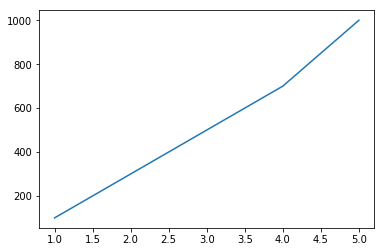

In [0]:
plt.plot(iteration, argumentlist)

**In here we do not know what the correct number of estimators or sub-models we want, hence let us cycle through a list with options**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6067953634273251


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7390212254837795


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7816154162537913


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7970717835245664


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8091488953687959


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8127816848585412


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8171649760612585


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8173587070462222


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8201898250992563


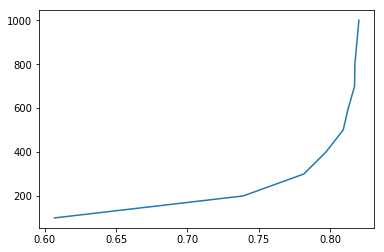

In [0]:
argumentlist = [100,200,300,400,500,600,700,800,1000]
scorelist = []

for i in argumentlist:
  gbr = GradientBoostingRegressor(n_estimators = i, learning_rate = 0.03)
  gbr.fit(xtrain,ytrain)  
  score_to_append = gbr.score(xtest,ytest)
  print(score_to_append)
  scorelist.append(score_to_append)
  
  
import matplotlib.pyplot as plt

plt.plot(scorelist, argumentlist, label='score')

The above plot gives us an understanding of how the score changes for each selection of estimators

In [0]:
#Now let's check variance of GBR by running split statement and then assesing score


#splitting the data
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30)

print(gbr.score(xtest,ytest))

0.9189803433390424


Split 1 - 0.9253486080131357

Split 2 - 0.8967617652947449

Split 3 - 0.771234655801339

Split 4 - 0.9189803433390424

---

The model shows some variance as we change the data.

In [0]:
t_iterationlist = [1,2,3,4,5,6,7,8,9,10]
t_scorelist = []

In [0]:
for i in t_iterationlist:
  t_scorelist.append(100)

In [0]:
print(t_scorelist)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


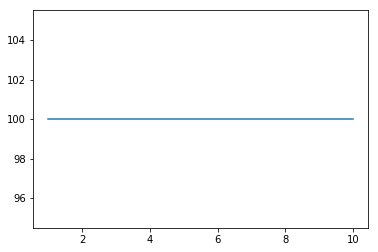

In [0]:
plt.plot(t_iterationlist,t_scorelist)

# Scaling the data for normalcy and then fitting models

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#df = scaler.fit(df)



In [0]:
scaleddf = scaler.fit_transform(df)

In [0]:
print(scaleddf)

[[ 2.62341796 -0.67260797 -1.0831221  ... -0.07210901 -1.25165577
  -1.21313424]
 [ 2.54356006 -0.57429739 -0.76520547 ... -0.0956865  -1.07989419
  -1.0989021 ]
 [ 2.49863999 -0.90668077 -0.92416378 ... -1.00211012 -1.16887974
  -1.05043998]
 ...
 [-0.06679515  0.31517926 -1.48051789 ... -0.73227881 -0.83282905
  -1.2555386 ]
 [ 1.22091354 -0.71474107  0.90385686 ... -1.27194143 -0.31643922
  -0.38581661]
 [-0.03185731 -0.56493448  1.06281518 ... -0.62748996  2.46731925
   2.53490022]]


In [0]:
scaleddf = pd.DataFrame(scaleddf, columns = ['longitude', 'latitude',	'housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_income',	'median_house_value'])

In [0]:
scaleddf.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-4.224638e-15,-3.277933e-15,1.975420e-16,-7.558953e-17,-1.300682e-16,-7.552847e-17,1.319722e-16,-1.111111e-16,-3.298029e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-2.387665e+00,-1.445048e+00,-2.195830e+00,-1.210816e+00,-1.276665e+00,-1.257765e+00,-1.305998e+00,-1.774571e+00,-1.662283e+00
25%,-1.109939e+00,-7.943258e-01,-8.446846e-01,-5.449952e-01,-5.753208e-01,-5.637014e-01,-5.750955e-01,-6.891682e-01,-7.553403e-01
50%,5.371302e-01,-6.445192e-01,2.958612e-02,-2.348302e-01,-2.472342e-01,-2.294898e-01,-2.371515e-01,-1.768829e-01,-2.361033e-01
75%,7.816951e-01,9.752646e-01,6.654194e-01,2.352423e-01,2.591604e-01,2.638700e-01,2.736942e-01,4.595006e-01,5.012133e-01
max,2.623418e+00,2.960202e+00,1.857607e+00,1.622046e+01,1.404355e+01,3.028809e+01,1.462453e+01,5.855874e+00,2.534900e+00


In [0]:
#using the scaled data to run variance trials

df = scaleddf

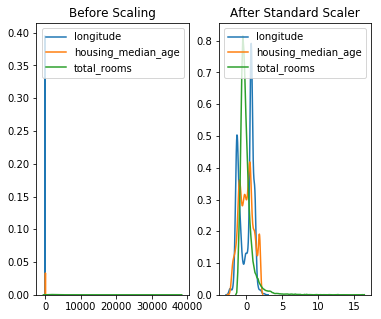

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['longitude'], ax=ax1)
sns.kdeplot(df['housing_median_age'], ax=ax1)
sns.kdeplot(df['total_rooms'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaleddf['longitude'], ax=ax2)
sns.kdeplot(scaleddf['housing_median_age'], ax=ax2)
sns.kdeplot(scaleddf['total_rooms'], ax=ax2)
plt.show()

# Normalise and fit


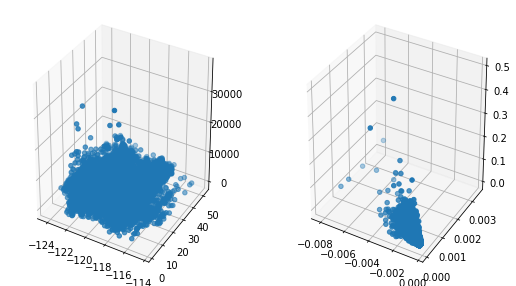

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing


scaler = preprocessing.Normalizer()
scaleddf = scaler.fit_transform(df)

scaleddf = pd.DataFrame(scaleddf, columns = ['longitude', 'latitude',	'housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_income',	'median_house_value'])



fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(df['longitude'], df['housing_median_age'], df['total_rooms'])
ax2.scatter(scaleddf['longitude'], scaleddf['housing_median_age'], scaleddf['total_rooms'])
plt.show()

# Ensembling for n iterations

In [0]:
scorelistada = []

iteration = [1,2,3,4,5] #,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
  
  ada = AdaBoostClassifier(n_estimators = 10)
  ada.fit(xtrain,ytrain)
  scoreada = ada.score(xtest,ytest)
  
  ''' 
  vardtree = DecisionTreeRegressor() #max_depth = 15 #min_samples_split
  vardtree.fit(xtrain,ytrain)
  scorevardtree = vardtree.score(xtest,ytest)
  
  
  
  scorelistvarlr.append(scorevarLR)
  scorelistvardtree.append(scorevardtree)
  '''
  scorelistada.append(scoreada)


'''  
plt.plot(iteration,scorelistvarlr, label = 'LR')
plt.plot(iteration,scorelistvardtree, label = 'Dtree')
'''
plt.plot(iteration,scorelistada)

  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: ignored

In [0]:
y.info()

In [0]:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
  
  ada = AdaBoostClassifier(n_estimators = 10)
  ada.fit(xtrain,ytrain)
  scoreada = ada.score(xtest,ytest)
  print(scoreada)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [0]:
print(ada.score(xtrain,ytrain))

0.0471206810215323


# Let's use cross validation to sample data sets

In [0]:

scorelistada = []

iteration = [1,2,3,4,5] #,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
  scores = cross_val_score(LR, x, y, cv=7)
  print(scores)

[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]


In [0]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
scores = cross_val_score(LR, x, y, cv=5)
print(scores)

[0.55730779 0.53843763 0.62391715 0.67984301 0.64000578]
